<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw10/combine_factors_and_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HW10 Pipeline

Factor: Sychology Utilities, Yuxing
* Sentiment
* Group confirmation
* Opinion leader

Factor: Intent, Mayuri
* Utterance
* Speech
* Sentiment

Reference: 
* https://towardsai.net/p/nlp/sentiment-analysis-opinion-mining-with-python-nlp-tutorial-d1f173ca4e3c
* https://github.com/towardsai/tutorials/tree/master/sentiment_analysis_tutorial
* https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/


## Data Preparation
* Scrape data from politifact
* Fetch twitter tweets by APIs

###Scrape data from politifact

In [68]:
!pip install -q beautifulsoup4
!pip install -q vaderSentiment

In [69]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup  

In [145]:
def scrape_data_from_politifact():
  url = "https://www.politifact.com/issues/"
  issues = []
  r = requests.get(url)
  soup = BeautifulSoup(r.text,'html.parser')
  results = soup.find_all('div', attrs={'class':'c-chyron__value'})
  for result in results:
    name = result.find('a').text
    issue = result.find('a')['href'].replace("/","")
    issues.append((name, issue))
  url = "https://www.politifact.com/factchecks/list/?page={pgno}&category={category}"

  records = []  

  for i in range(2,6):
    for issue, issue_url in issues:
      fUrl = url.format(pgno=str(i), category=issue_url)
      r = requests.get(fUrl)
      soup = BeautifulSoup(r.text, 'html.parser')  
      results = soup.find_all('article', attrs={'class':'m-statement'})
      for result in results:
        date = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[1].rstrip("\n")
        reporter = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[0].replace("\nBy","")   
        author = result.find('a',attrs={'class':'m-statement__name'}).text.replace("\n","")
        statement =  result.find('div', attrs = {'class':'m-statement__quote'}).find('a').text.replace("\n","")
        statement_descr = result.find('div', {'class':'m-statement__desc'}).text.replace("\n","")
        article_url =  result.find('a')['href']
        verdict = result.find('img', attrs = {'class':'c-image__thumb'}, alt=True).attrs['alt']
        records.append(( date, issue, reporter, author, statement, statement_descr, verdict, article_url))
  return records

df_sample = pd.DataFrame(records, columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  
df_sample.head()

,Date,Issue,Reporter,Author,Statement,Description,Verdict,Url
0,"March 31, 2021",Abortion,Tom Kertscher,Facebook posts,“Joe Biden puts pro-life groups on domestic ex...,"stated on March 29, 2021 in a Facebook post:",barely-true,/personalities/facebook-posts/
1,"February 12, 2021",Abortion,Brandon Mulder,Greg Abbott,“Innocent lives will be saved” by ending taxpa...,"stated on January 24, 2021 in a tweet:",false,/personalities/greg-abbott/
2,"November 18, 2020",Abortion,Noah Y. Kim,Facebook posts,There is “aborted male fetus” in the Oxford-As...,"stated on November 15, 2020 in a Facebook post:",false,/personalities/facebook-posts/
3,"October 14, 2020",Abortion,Tom Kertscher,Tommy Tuberville,"Says Doug Jones ""has voted to spend our tax do...","stated on October 8, 2020 in an ad:",false,/personalities/tommy-tuberville/
4,"October 13, 2020",Abortion,Chris Nichols,Facebook posts,“Kamala Harris Tried to Put Pro-Lifers in Jail...,"stated on August 14, 2020 in a headline:",false,/personalities/facebook-posts/


In [146]:
df_sample.shape

(102, 8)

**Import Required Packages**

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import requests
import string
from string import punctuation
from sklearn.preprocessing import StandardScaler
from io import BytesIO
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Load less biased twitter data set for training**

In [74]:
train_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-7fkaGbvXcppizTYkyM_weWptbtyab7PVUXJZdpJb7aJ-mKXtB1zTkY7DizLU7M64oYMoE8lPJQ1V/pub?output=csv'
r = requests.get(train_url)
data = r.content
df_train = pd.read_csv(BytesIO(data))
df_train.shape

(762, 3)

###Scrape data from twitter

In [75]:
!pip install -q datasketch
!pip install -q networkx 

In [76]:
import tweepy
from tweepy import OAuthHandler
import pandas as pd
import numpy as np
import re
import time
from datasketch import MinHash, MinHashLSH

In [77]:
access_token = '1311987544507084800-iYuPqERzopIZuuyxaZ8xnqARcyKrR1'
access_token_secret = 'DCJg5kE7srBZRToNlzF0xqT3hcxonnXMlMXKWjX91wyTe'
consumer_key = 'YQLJJb0ELY5pdXbx7WkQXtRXo'
consumer_secret = 'HCgQga7Mj33C5E19IP7Dr3qGChmc85M6IEYXSGtI6g4cdplBYw'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

tweets = []

count = 1

"""if you don't add since= as one of the parameters, Twitter will sample the last 7 days worth of data depending
on how many total tweets there are with the specific hashtag, keyword, or key phrase that you are looking for. You can
manually add in the number of items (or tweets) you want to get back in the items() section."""

for tweet in tweepy.Cursor(api.search, q="#breaking", count=450, since='2020-04-10', lang='en').items(5000):
  count += 1
  try:
    data = [tweet.text, tweet.retweet_count, tweet.user.followers_count]
    data = tuple(data)
    tweets.append(data)
  
  except tweepy.TweepError as e:
    print(e.reason)
    continue

  except StopIteration:
    break

df_tweet = pd.DataFrame(tweets, columns = ['Statement', 'NumOfRetweets', 'UserNumOfFollowers'])
df_tweet = df_tweet[:1000]
df_tweet.head()

,Statement,NumOfRetweets,UserNumOfFollowers
0,RT @SwainForSenate: #BREAKING Governor Desanti...,345,15
1,RT @keribla: #BREAKING For the first time in 9...,138,1062
2,RT @FriendsofAlAqsa: ‼️#BREAKING‼️ Israeli pol...,9,23
3,RT @ABC7: #BREAKING California reports first y...,27,874
4,"RT @AFP: #BREAKING Israeli police, Palestinian...",30,34


**Text Preprocessing**

In [78]:
df = df_tweet.copy()

In [79]:
stopwords = stopwords.words('english')
stopwords.append(['breaking', 'BREAKING'])

def get_text_processing(text):
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stopwords])

In [80]:
df['Statement'] = df['Statement'].apply(get_text_processing)

##Individual Work

### Microfactors generation (Yuxing)

**Generate Microfactors for Factor PsychologyUtilites**

**1. Group Confirmation**

The more retweets, the more social confirmation. We split the number of retwees to 'Confirmation' as 'positive' and 'negative', 300 is the threshold we can use for a 'strong' confirmation or not.

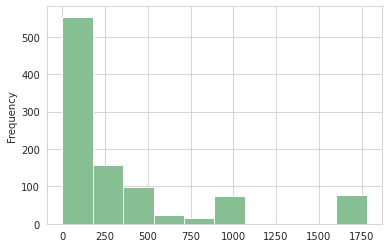

In [81]:
pd.options.mode.chained_assignment = None

ulimit = np.percentile(df.NumOfRetweets, 99)
df['NumOfRetweets'].loc[df['NumOfRetweets']>ulimit] = ulimit
llimit = np.percentile(df.NumOfRetweets.values, 1)
df['NumOfRetweets'].loc[df['NumOfRetweets']<llimit] = llimit
df['NumOfRetweets'].plot.hist(color='#86bf91')

In [82]:
def gen_microfactor_confirmation(df):
  df['ScaleConfirmation'] = df['NumOfRetweets']/df['NumOfRetweets'].mean()
  df['ScaleConfirmation'] = df['ScaleConfirmation'].apply(lambda x: 1 if x > 1 else x)
  df['Confirmation'] = df['ScaleConfirmation'].apply(lambda x: 'Positive' if x > 0.2 else 'Negative')

gen_microfactor_confirmation(df)

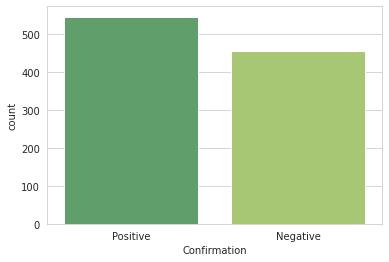

In [83]:
sns.set_style('whitegrid')
sns.countplot(x='Confirmation',data=df, palette='summer')

**2. Author Sentiment**

We use SentimentIntensityAnalyzer to detect the score of sentiment.

In [84]:
def get_text_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  _sentiment = analyzer.polarity_scores(text)["compound"]
  return abs(_sentiment)

In [85]:
df['ScaleSentiment'] = df['Statement'].apply(get_text_sentiment)
df['Sentiment'] = df['ScaleSentiment'].apply(lambda x: 'Positive' if float(x) > 0.4 else 'Negative')

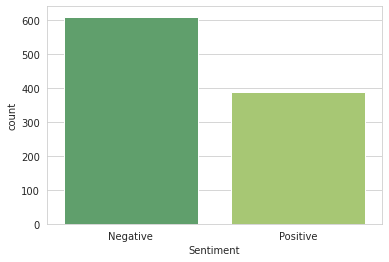

In [86]:
sns.set_style('whitegrid')
sns.countplot(x='Sentiment',data=df, palette='summer')

**3. Opinion Leader**

The opinion leaders are people who have many followers, we will use use number of followers of twitter user to detect the score of opinion leader.

In [87]:
def gen_microfactor_opinionleader(df):
  df['ScaleOpinionLeader'] = df['UserNumOfFollowers']/df['UserNumOfFollowers'].mean()
  df['ScaleOpinionLeader'] = df['ScaleOpinionLeader'].apply(lambda x: 1 if x > 1 else x)
  df['OpinionLeader'] = df['ScaleOpinionLeader'].apply(lambda x: 'Positive' if x > 0.2 else 'Negative')

gen_microfactor_opinionleader(df)

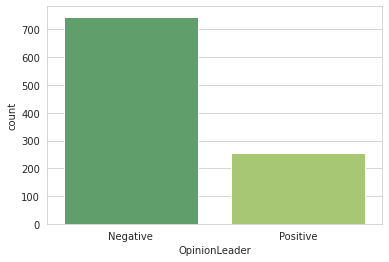

In [88]:
sns.set_style('whitegrid')
sns.countplot(x='OpinionLeader',data=df, palette='summer')

### Factor generation(Yuxing)
* Combine micro-factors to factor PsychologyUtilites using polynomial

In [89]:
# Get factor from micro factors by polynomial
df['ScalePsychology'] = df['ScaleConfirmation'] * 0.34 + df['ScaleSentiment'] * 0.33 + df['ScaleOpinionLeader'] * 0.33
df['PsychologyUtilites'] = df['ScalePsychology'].apply(lambda x: 'Positive' if x > 0.3 else 'Negative')

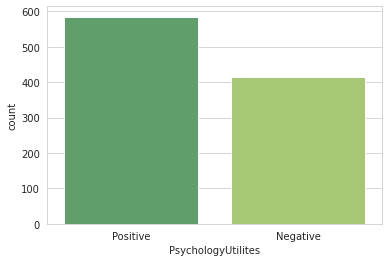

In [90]:
sns.set_style('whitegrid')
sns.countplot(x='PsychologyUtilites',data=df, palette='summer')

In [91]:
df.shape

(1000, 11)

**Construct a pipeline model with count vector Tfidf vector inside**

Pipeline includes vectorization tfidf transformer and SVM training

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib

# A pipeline with data preprocessing, training and prediction
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC(C=1, probability=True))
])

def data_to_pipeline(df, _source=None, _target=None):
  # Split data for training and validation
  X, y = df[_source].values, df[_target].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
  
  # Training and prediction
  pipeline.fit(X_train, y_train)
  scores = cross_val_score(pipeline, X_test, y_test, cv=3)
  print('now using %s to predict %s' % (_source, _target))
  print('cross validation scores:', scores)
  print('prediction score:', pipeline.score(X_test, y_test))
  print('\n')

  # Save the pickle file
  joblib.dump(pipeline, '/content/' + _target + '_pipeline.pkl')

In [93]:
def factor_1_pipeline(df):
  data_to_pipeline(df, _source='Statement', _target='Sentiment')
  data_to_pipeline(df, _source='Statement', _target='Confirmation')
  data_to_pipeline(df, _source='Statement', _target='OpinionLeader')
  data_to_pipeline(df, _source='Statement', _target='PsychologyUtilites')

factor_1_pipeline(df)

now using Statement to predict Sentiment
cross validation scores: [0.9  0.9  0.91]
prediction score: 0.9366666666666666


now using Statement to predict Confirmation
cross validation scores: [0.95 0.88 0.9 ]
prediction score: 0.9666666666666667


now using Statement to predict OpinionLeader
cross validation scores: [0.77 0.77 0.75]
prediction score: 0.7833333333333333


now using Statement to predict PsychologyUtilites
cross validation scores: [0.87 0.81 0.88]
prediction score: 0.8866666666666667




### Microfactors generation (Mayuri)

**Generate Microfactors for Factor Intent**

**1. Utterance Score**

Where there are more sentences, there are more utterances. We can derive utterance from numberof sentences in the text.

In [30]:
from collections import Counter
import spacy

nlp = spacy.load('en_core_web_sm')

def get_sentences_num(text):
  _doc = nlp(text)
  sentences = list(_doc.sents)
  return len(sentences)

df['NumOfSent'] = df['Statement'].apply(get_sentences_num)

In [31]:
def gen_microfactor_utterance(df):
  df['ScaleUtterance'] = df['NumOfSent']/df['NumOfSent'].mean()
  df['ScaleUtterancen'] = df['ScaleUtterance'].apply(lambda x: 1 if x > 1 else x)
  df['Utterance'] = df['ScaleUtterance'].apply(lambda x: 'Positive' if x > 0.9 else 'Negative')

gen_microfactor_utterance(df)

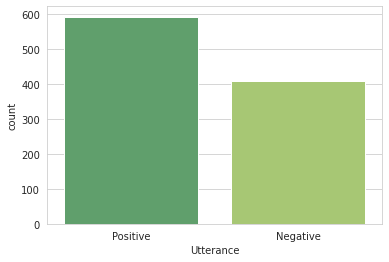

In [32]:
sns.set_style('whitegrid')
sns.countplot(x='Utterance',data=df, palette='summer')

**2.Speech Score**

Where there are more verbs and nouns, there are more speech to make. We can derive speech from numberof verbs and nouns in the text.

In [33]:
def get_verbnoun_num(text):
  _doc = nlp(text)
  _no_stopword_doc = [token for token in _doc if not token.is_stop]
  return len(_no_stopword_doc)

df['NumOfVerbNoun'] = df['Statement'].apply(get_verbnoun_num)

In [34]:
def gen_microfactor_speech(df):
  df['ScaleSpeech'] = df['NumOfVerbNoun']/df['NumOfVerbNoun'].mean()
  df['ScaleSpeech'] = df['ScaleSpeech'].apply(lambda x: 1 if x > 1 else x)
  df['Speech'] = df['ScaleSpeech'].apply(lambda x: 'Positive' if x > 0.95 else 'Negative')

gen_microfactor_speech(df)

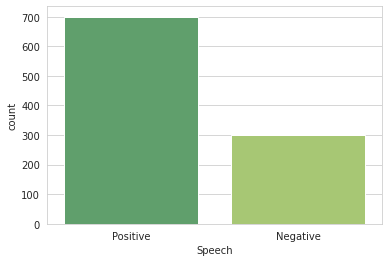

In [35]:
sns.set_style('whitegrid')
sns.countplot(x='Speech',data=df, palette='summer')

**3.Sentiment**

Sentiment is a micro factor of intent, also it is micro factor of psychology utility, which has been derived earlier.

In [36]:
df['ScaleSentiment'].head()

0    0.4767
1    0.3182
2    0.4404
3    0.3182
4    0.0000
Name: ScaleSentiment, dtype: float64

### Factor generation(Mayuri)
* Combine micro-factors to factor Intent using polynomial

In [37]:
# Get factor from micro factors by polynomial
df['ScaleIntent'] = df['ScaleUtterancen'] * 0.3 + df['ScaleSpeech'] * 0.3 + df['ScaleSentiment'] * 0.4
df['Intent'] = df['ScaleIntent'].apply(lambda x: 'Positive' if x > 0.65 else 'Negative')

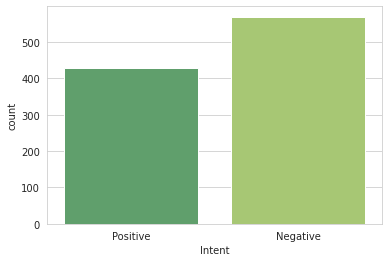

In [38]:
sns.set_style('whitegrid')
sns.countplot(x='Intent',data=df, palette='summer')

In [39]:
def factor_2_pipeline(df):
  data_to_pipeline(df, _source='Statement', _target='Utterance')
  data_to_pipeline(df, _source='Statement', _target='Speech')
  data_to_pipeline(df, _source='Statement', _target='Intent')

factor_2_pipeline(df)

now using Statement to predict Utterance
cross validation scores: [0.88 0.89 0.9 ]
prediction score: 0.92


now using Statement to predict Speech
cross validation scores: [0.9  0.96 0.87]
prediction score: 0.95


now using Statement to predict Intent
cross validation scores: [0.87 0.82 0.86]
prediction score: 0.92




## Team Work

###Load the pickled models for microfactors

In [117]:
! ls -l /content/*.pkl

-rw-r--r-- 1 root root 156019 May  7 18:46 /content/Confirmation_pipeline.pkl
-rw-r--r-- 1 root root 143141 May  7 18:09 /content/Intent_pipeline.pkl
-rw-r--r-- 1 root root 190435 May  7 18:46 /content/OpinionLeader_pipeline.pkl
-rw-r--r-- 1 root root 165895 May  7 18:46 /content/PsychologyUtilites_pipeline.pkl
-rw-r--r-- 1 root root 154639 May  7 18:46 /content/Sentiment_pipeline.pkl
-rw-r--r-- 1 root root 143945 May  7 18:09 /content/Speech_pipeline.pkl
-rw-r--r-- 1 root root 147185 May  7 18:09 /content/Utterance_pipeline.pkl
-rw-r--r-- 1 root root  11246 May  7 19:03 /content/Verdict_pipeline.pkl


In [109]:
import joblib

microfactor_list = [
                    'Sentiment', 
                    'Confirmation', 
                    'OpinionLeader',
                    'Utterance',
                    'Speech',
                    'Intent'
                  ]

def get_micrafactor_from_pickles_(df):
  # Preprocessing
  df['Statement'] = df['Statement'].apply(get_text_processing)
  statement = df['Statement'].to_numpy()
  for microfactor in microfactor_list:
    print('generating microfactor :', microfactor)
    # load microfactor pickle
    pickle_filepath = '/content/{}_pipeline.pkl'.format(microfactor)
    microfactor_model = joblib.load(open(pickle_filepath, 'rb'))
    # create new microfact column
    y_microfactor = microfactor_model.predict(statement)
    df[microfactor] = y_microfactor
    df[microfactor] = df[microfactor].apply(lambda x: 1 if x == 'Positive' else 0)
    

In [110]:
df = df_sample.copy()
get_micrafactor_from_pickles_(df)

handling : Sentiment
handling : Confirmation
handling : OpinionLeader
handling : Utterance
handling : Speech
handling : Intent


###Ensemble a true-o-meter classification pipeline

In [116]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('svm', SVC(C=1, probability=True))
])

data_to_pipeline(df, _source=microfactor_list, _target='Verdict')

now using ['Sentiment', 'Confirmation', 'OpinionLeader', 'Utterance', 'Speech', 'Intent'] to predict Verdict
cross validation scores: [0.36363636 0.4        0.3       ]
prediction score: 0.3870967741935484




/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


###Automated Inference Pipeline
Read a new piece of data from politifact

In [124]:
df = pd.DataFrame(records, columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  
df['Statement'] = df['Statement'].apply(get_text_processing)

handling : Sentiment
handling : Confirmation
handling : OpinionLeader
handling : Utterance
handling : Speech
handling : Intent


Load pickled true-o-meter pipeline

In [125]:
get_micrafactor_from_pickles_(df)
pickle_filepath = '/content/Verdict_pipeline.pkl'
o_meter_model = joblib.load(open(pickle_filepath, 'rb'))
pred_verdict = o_meter_model.predict(df[microfactor_list])
df['pred_verdict'] = pred_verdict

In [135]:
df_intestest = df[['Statement', 'Verdict', 'pred_verdict']]
df_intestest.head()

,Statement,Verdict,pred_verdict
0,“Joe Biden puts prolife groups domestic extrem...,barely-true,false
1,“Innocent lives saved” ending taxpayer funding...,false,false
2,“aborted male fetus” OxfordAstraZeneca “Covid ...,false,false
3,Says Doug Jones voted spend tax dollars latete...,false,false
4,“Kamala Harris Tried Put ProLifers Jail Expose...,false,false
